In [98]:
# StackOverlow Developer Survey - Data Cleaning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import re
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

In [99]:
# 1. Load the dataset
print("1. Loading the dataset...")
df = pd.read_csv('../data/raw/survey_results_public.csv')
print("Dataset loaded successfully.")
print(f"Initial shape: {df.shape}")

1. Loading the dataset...
Dataset loaded successfully.
Initial shape: (49123, 170)


In [100]:
# 2. Basic Information
print("\n2. Basic information...")
print(f"Dataset size: {df.shape[0]} rows, {df.shape[1]} columns")


2. Basic information...
Dataset size: 49123 rows, 170 columns


In [101]:
# 3. Define target variable - We're predicting salary
print("\n3. Identifying target variable...")
target_column = 'ConvertedCompYearly'
if target_column in df.columns:
    print(f"Target variable: {target_column}")
    print(f"Target variable stats:\n{df[target_column].describe()}")
    
    # Check for missing values in target
    target_missing = df[target_column].isna().sum()
    print(f"Missing values in target: {target_missing} ({target_missing/len(df)*100:.2f}%)")
else:
    print(f"target variable '{target_column}' not found in dataset.")


3. Identifying target variable...
Target variable: ConvertedCompYearly
Target variable stats:
count    2.392800e+04
mean     1.017916e+05
std      4.619345e+05
min      1.000000e+00
25%      3.817100e+04
50%      7.538350e+04
75%      1.206302e+05
max      5.000000e+07
Name: ConvertedCompYearly, dtype: float64
Missing values in target: 25195 (51.29%)


In [102]:
# 4. Analyze missing values....")
print("\n4. Analyzing missing values...")
missing_counts = df.isnull().sum()
missing_percentage = (missing_counts / len(df)) * 100
missing_df = pd.DataFrame({
    'Column': missing_counts.index,
    'Missing_Count': missing_counts.values,
    'Missing_Percentage': missing_percentage.values
}).sort_values('Missing_Percentage', ascending=False)

print("Top 10 columns with most missing data:")
print(missing_df.head(10))


4. Analyzing missing values...
Top 10 columns with most missing data:
                   Column  Missing_Count  Missing_Percentage
163       AIAgentObsWrite          48859           99.462574
96       SOTagsWant Entry          48693           99.124646
95        SOTagsHaveEntry          48666           99.069682
114     AIModelsWantEntry          48649           99.035075
161      AIAgentOrchWrite          48646           99.028968
54   JobSatPoints_15_TEXT          48459           98.648291
159      AIAgentKnowWrite          48358           98.442685
113     AIModelsHaveEntry          48348           98.422328
130    SO_Actions_15_TEXT          48300           98.324614
165       AIAgentExtWrite          48265           98.253364


In [103]:
# 5. Drop columns with excessive missing data
print("\n5. Dropping columns with excessive missing data...")
# Drop columns with more than 60% missing values
high_missing_cols = missing_df[missing_df['Missing_Percentage'] > 60]['Column'].tolist()
print(f"Dropping {len(high_missing_cols)} columns with > 50% missing data:")

#P Print columns in alphabetical order
for col in sorted(high_missing_cols):
    print(f" - {col} ({missing_df[missing_df['Column']==col]['Missing_Percentage'].values[0]:.1f}%)")
    
df_cleaned = df.drop(columns=high_missing_cols)

# Print shape difference
initial_shape = df.shape
cleaned_shape = df_cleaned.shape
cols_removed = initial_shape[1] - cleaned_shape[1]
print(f"Dataset shape after dropping high-missing columns: {df_cleaned.shape}")
print(f"Columns removed: {cols_removed} ({cols_removed/initial_shape[1]*100:.1f}% of original columns)")
print(f"Shape difference: {initial_shape} -> {cleaned_shape}")


5. Dropping columns with excessive missing data...
Dropping 53 columns with > 50% missing data:
 - AIAgentChallengesSomewhat disagree (75.3%)
 - AIAgentChallengesStrongly disagree (81.1%)
 - AIAgentExtWrite (98.3%)
 - AIAgentExternal (83.1%)
 - AIAgentImpactNeutral (80.3%)
 - AIAgentImpactSomewhat agree (79.4%)
 - AIAgentImpactSomewhat disagree (88.2%)
 - AIAgentImpactStrongly agree (86.4%)
 - AIAgentImpactStrongly disagree (92.3%)
 - AIAgentKnowWrite (98.4%)
 - AIAgentKnowledge (93.1%)
 - AIAgentObsWrite (99.5%)
 - AIAgentObserveSecure (94.5%)
 - AIAgentOrchWrite (99.0%)
 - AIAgentOrchestration (92.3%)
 - AIAgent_Uses (74.9%)
 - AIModelsAdmired (77.1%)
 - AIModelsHaveEntry (98.4%)
 - AIModelsHaveWorkedWith (66.9%)
 - AIModelsWantEntry (99.0%)
 - AIModelsWantToWorkWith (75.9%)
 - AIToolCurrently mostly AI (77.2%)
 - AIToolPlan to mostly use AI (73.9%)
 - AgentUsesGeneral (88.2%)
 - CommPlatformHaveEntr (97.0%)
 - CommPlatformWantEntr (97.6%)
 - DatabaseAdmired (64.8%)
 - DatabaseHaveE

In [104]:
# 6. Drop rows with missing target variable
print(f"\n6. Checking target variable: {target_column} and dropping missing rows")

if target_column in df_cleaned.columns:
    initial_rows = len(df_cleaned)
    missing_target = df_cleaned[target_column].isna().sum()
    print(f"Missing target values: {missing_target} out of {initial_rows} rows ({missing_target/initial_rows*100:.2f}%)")
    
    if missing_target > 0:
        # Drop rows with missing target values
        df_cleaned = df_cleaned.dropna(subset=[target_column])
        remaining_rows = len(df_cleaned)
        print(f"Dropped {initial_rows - remaining_rows} rows with missing target values")
        print(f"Remaining rows: {remaining_rows}")
    else:
        print("No missing target values to drop")
else:
    print(f"Warning: Target column '{target_column}' not found in dataset")

print(f"Dataset shape after handling missing targets: {df_cleaned.shape}")


6. Checking target variable: ConvertedCompYearly and dropping missing rows
Missing target values: 25195 out of 49123 rows (51.29%)
Dropped 25195 rows with missing target values
Remaining rows: 23928
Dataset shape after handling missing targets: (23928, 117)


In [105]:
# 7. Drop columns irrelevant to salary prediction
print("\n7. Dropping irrelevant columns...")
# These are columns that I deemed unlikely to help predict salary from exploratory analysis and domain knowledge
irrelevant_cols = [
    'ResponseId', # Unique identifier for each response
    'LearnCodeAI', # Did you spend time in the last year learning AI programming or AI-enabled tooling on your own or at work?
    # ^ AI not involved in salary prediction, I know some dumb programmers that learned AI
    'AILearnedHow', # How did you learn to code for AI in the past year? Select all that apply.
    # ^ Method in which AI was learned also not relevant
    'TechOppose_15_TEXT', # Text entry for tech oppose question
    'JobSatPoints_15_TEXT', # Text entry for job satisfaction question
    'Currency', # related to salary - target variable is already in USD
    'CompTotal', # related to salary - target variable is already in USD
    'LanguagesHaveEntry', # Lot of empty values, not relevant
    'LanguagesWantEntry', # Lot of empty values, not relevant
    'DatabaseAdmired', # May include useful info, will test with model later
    'WebframeAdmired', # May include useful info, will test with model later
    'DevEnvsHaveWorkedWith', # May include useful info, will test with model later
    'DevEnvsWantToWorkWith', # May include useful info, will test with model later
    'DevEnvsAdmired', # May include useful info, will test with model later
    'SOTagsHaveWorkedWith', # May include useful info, will test with model later
    'SOTagsWantToWorkWith', # May include useful info, will test with model later
    'SOTagsAdmired', # May include useful info, will test with model later
    'OfficeStackAsyncHaveWorkedWith', # To many different responses, responses are not related to each other too random
    'OfficeStackAsyncWantToWorkWith', # To many different responses, responses are not related to each other too random
    'OfficeStackAsyncAdmired', # To many different responses, responses are not related to each other too random
    'CommPlatformAdmired', # To many different responses, responses are not related to each other too random
    # I will keep most AI related questions out of model development for now, may add later to see if it affects model output
    'AIModelsChoice', # Not relevant to salary prediction
    'AIModelsHaveWorkedWith', # Not relevant to salary prediction
    'AIModelsWantToWorkWith', # Not relevant to salary prediction
    'AIModelsAdmired', # Not relevant to salary prediction
    'AISelect', # Not relevant to salary prediction
    'AISent', # Not relevant to salary prediction
    'AIAcc', # Not relevant to salary prediction
    'AIComplex', # Not relevant to salary prediction
    'AIToolCurrently partially AI', # Not relevant to salary prediction
    'AIToolDon\'t plan to use AI for this task', # Not relevant to salary prediction
    'AIToolPlan to partially use AI', # Not relevant to salary prediction
    'AIToolPlan to mostly use AI', # Not relevant to salary prediction
    'AIToolCurrently mostly AI', # Not relevant to salary prediction
    'AIFrustration', # Not relevant to salary prediction
    'AIExplain', # Not relevant to salary prediction
    'AIAgents', # Not relevant to salary prediction
    'AIAgentChange', # Not relevant to salary prediction
    'AIAgent_Uses', # Not relevant to salary prediction
    'AgentUsesGeneral', # Not relevant to salary prediction
    'AIAgentImpactSomewhat agree', # Not relevant to salary prediction
    'AIAgentImpactNeutral', # Not relevant to salary prediction
    'AIAgentImpactSomewhat disagree', # Not relevant to salary prediction
    'AIAgentChallengesNeutral', # Not relevant to salary prediction
    'AIAgentChallengesSomewhat disagree', # Not relevant to salary prediction
    'AIAgentChallengesStrongly agree', # Not relevant to salary prediction
    'AIAgentChallengesStrongly disagree', # Not relevant to salary prediction
    'AIAgentChallengesSomewhat agree', # Not relevant to salary prediction
    'AIAgentExternal', # Not relevant to salary prediction
    'AIHuman', # Not relevant to salary prediction
    'AIOpen', # Not relevant to salary prediction
    'AILearnHow', # Not relevant to salary prediction
    'AIThreat', # Not relevant to salary prediction
    # Add more irrelevant columns
]

# Filter to only keep columns that actually exist
irrelevant_cols = [col for col in irrelevant_cols if col in df_cleaned.columns]
df_cleaned = df_cleaned.drop(columns=irrelevant_cols)
print(f"Dropped {len(irrelevant_cols)} irrelevant columns")
print(f"Dataset shape after dropping irrelevant columns: {initial_shape} -> {df_cleaned.shape}")


7. Dropping irrelevant columns...
Dropped 29 irrelevant columns
Dataset shape after dropping irrelevant columns: (49123, 170) -> (23928, 88)


In [106]:
# 8. Handle missing values in remaining columns
print("\n8. Handling missing values...")
numerical_cols = df_cleaned.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df_cleaned.select_dtypes(include=['object']).columns

# Impute numerical columns with median
for col in numerical_cols:
    if df_cleaned[col].isna().sum() > 0:
        df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].median())

# Impute categorical columns with 'Unknown'
for col in categorical_cols:
    if df_cleaned[col].isna().sum() > 0:
        df_cleaned[col] = df_cleaned[col].fillna('Unknown')
        
print(f"Missing values after imputation: {df_cleaned.isna().sum().sum()}")


8. Handling missing values...
Missing values after imputation: 0



9. Handling outliers in salary data...
Found 1061 outliers in the salary data


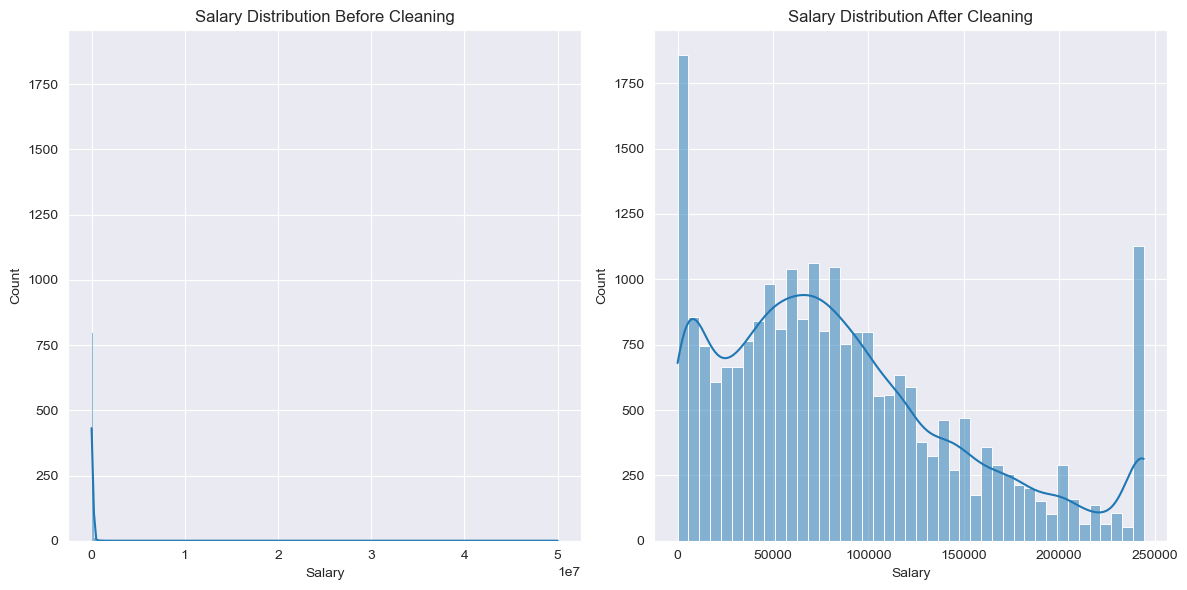

In [107]:
# 9. Handle outliers in target variable
print("\n9. Handling outliers in salary data...")
if target_column in df_cleaned.columns:
    Q1 = df_cleaned[target_column].quantile(0.25)
    Q3 = df_cleaned[target_column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Plot before removing outliers
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(df_cleaned[target_column].dropna(), kde=True)
    plt.title('Salary Distribution Before Cleaning')
    plt.xlabel('Salary')
    
    # Remove outliers
    outliers = ((df_cleaned[target_column] < lower_bound) | 
                (df_cleaned[target_column] > upper_bound))
    print(f"Found {outliers.sum()} outliers in the salary data")
    
    # Either remove outliers or cap them
    # Option 1: Remove
    # df_cleaned = df_cleaned[~outliers]
    
    # Option 2: Cap (using this as default)
    df_cleaned.loc[df_cleaned[target_column] < lower_bound, target_column] = lower_bound
    df_cleaned.loc[df_cleaned[target_column] > upper_bound, target_column] = upper_bound
    
    # Plot after handling outliers
    plt.subplot(1, 2, 2)
    sns.histplot(df_cleaned[target_column].dropna(), kde=True)
    plt.title('Salary Distribution After Cleaning')
    plt.xlabel('Salary')
    plt.tight_layout()
    plt.show()

In [108]:
# 10. Encode categorical variables
print("\n10. Encoding categorical variables...")

# Define multi-value columns (semicolon-separated values)
multi_value_cols = [
    'LanguageHaveWorkedWith', 
    'LanguageWantToWorkWith',
    'LanguageAdmired',
    'DatabaseHaveWorkedWith', 
    'DatabaseWantToWorkWith',
    'PlatformHaveWorkedWith', 
    'PlatformWantToWorkWith',
    'WebframeHaveWorkedWith', 
    'WebframeWantToWorkWith',
    'OpSysPersonal use', 
    'OpSysProfessional sue',
    'CommPlatformHaveWorkedWith',
    'CommPlatformWantToWorkWith',
    'SO_Dev_Content',
    'EmploymentAddl',
    'LearnCode'
]

# Filter to only include columns that actually exist in the dataset
multi_value_cols = [col for col in multi_value_cols if col in df_cleaned.columns]
print(f"Found {len(multi_value_cols)} multi-value columns to process")


10. Encoding categorical variables...
Found 13 multi-value columns to process


In [109]:
# Function to create binary columns for multi-value fields
def create_binary_features_from_multi_value(df, column_name, min_frequency=0.01):
    """
    Convert semicolon-separated multi-value column to binary features
    
    :param df: DataFrame
    :param column_name: str, name of the column to process
    :param min_frequency: float, minimum frequency threshold for including a value (default 1%)
    :return: DataFrame with new binary columns
    """
    # Get all unique values across all rows
    all_values = set()
    for values_str in df[column_name].dropna():
        if pd.notna(values_str) and values_str != '':
            values = [v.strip() for v in str(values_str).split(';') if v.strip()]
            all_values.update(values)
    
    # Calculate frequency of each value
    value_counts = {}
    total_rows = len(df)
    
    for value in all_values:
        count = df[column_name].str.contains(f'\\b{re.escape(value)}\\b', na=False, regex=True).sum()
        value_counts[value] = count / total_rows
        
    # Filter values by minimum frequency
    frequent_values = [value for value, freq in value_counts.items() if freq >= min_frequency]
    print(f"  {column_name}: {len(all_values)} unique values, {len(frequent_values)} above {min_frequency*100}% frequency")
    
    # Create binary columns for frequent values
    new_columns = {}
    for value in frequent_values:
        # Clean column name for valid Python identifier
        clean_value = re.sub(f'[^\w\s]', '', value).replace(' ', '-')
        col_name = f"{column_name}_{clean_value}"
        
        # Create binary column
        new_columns[col_name] = df[column_name].str.contains(
            f'\\b{re.escape(value)}\\b', na=False, regex=True
        ).astype(int)
    
    return pd.DataFrame(new_columns)

In [110]:
# Process multi-value columns
df_with_multi_value = df_cleaned.copy()
multi_value_features = []

for col in multi_value_cols:
    if col in df_cleaned.columns:
        print(f"Processing multi-value column: {col}")
        binary_features = create_binary_features_from_multi_value(df_cleaned, col)
        df_with_multi_value = pd.concat([df_with_multi_value, binary_features], axis=1)
        multi_value_features.extend(binary_features.columns.tolist())
        
print(f"Created {len(multi_value_features)} binary features from multi-value columns")

# Update categorical columns list (exclude the original multi-value columns)
remaining_categorical_cols = [col for col in categorical_cols if col not in multi_value_cols]

# Use Label Encoding for binary variables (excluding multi-value derived columns)
binary_cols = [
    col for col in remaining_categorical_cols
    if df_with_multi_value[col].nunique() == 2
]

label_encoder = LabelEncoder()
for col in binary_cols:
    df_with_multi_value[f'{col}_encoded'] = label_encoder.fit_transform(
        df_with_multi_value[col].astype(str)
    )
    
print(f"Label encoded {len(binary_cols)} binary columns")

# One-hot encode remianing categorical variables with low cardinality
low_cardinality_cols = [
    col for col in remaining_categorical_cols
    if (2 < df_with_multi_value[col].nunique() <= 10 and
        col not in binary_cols)
]

if low_cardinality_cols:
    df_encoded = pd.get_dummies(
        df_with_multi_value,
        columns=low_cardinality_cols,
        drop_first=True
    )
    print(f"One-hot encoded {len(low_cardinality_cols)} low-cardinality columns")
else:
    df_encoded = df_with_multi_value.copy()
    print("No low-cardinality columns to one-hot encode")
    
# Handle high cardinality columns (optional - might want to use target encoding later)
high_cardinality_cols = [
    col for col in remaining_categorical_cols
    if (df_with_multi_value[col].nunique() > 10 and col not in binary_cols)
]

if high_cardinality_cols:
    print(f"High cardinality columns detected (>10 unique values): {high_cardinality_cols}")
    print("Consider target encoding or frequency encoding for these in feature engineering step.")

Processing multi-value column: LanguageHaveWorkedWith
  LanguageHaveWorkedWith: 43 unique values, 32 above 1.0% frequency
Processing multi-value column: LanguageWantToWorkWith
  LanguageWantToWorkWith: 43 unique values, 36 above 1.0% frequency
Processing multi-value column: LanguageAdmired
  LanguageAdmired: 43 unique values, 25 above 1.0% frequency
Processing multi-value column: DatabaseHaveWorkedWith
  DatabaseHaveWorkedWith: 31 unique values, 28 above 1.0% frequency
Processing multi-value column: DatabaseWantToWorkWith
  DatabaseWantToWorkWith: 31 unique values, 28 above 1.0% frequency
Processing multi-value column: PlatformHaveWorkedWith
  PlatformHaveWorkedWith: 43 unique values, 38 above 1.0% frequency
Processing multi-value column: WebframeHaveWorkedWith
  WebframeHaveWorkedWith: 29 unique values, 29 above 1.0% frequency
Processing multi-value column: OpSysPersonal use
  OpSysPersonal use: 16 unique values, 14 above 1.0% frequency
Processing multi-value column: CommPlatformHaveW

In [111]:
# Summary of transformations
print(f"\n=== Encoding Summary ===")
print(f"Original dataset shape: {df_cleaned.shape}")
print(f"Multi-value columns processed: {len(multi_value_cols)}")
print(f"Binary features created from multi-value: {len(multi_value_features)}")
print(f"Binary columns label encoded: {len(binary_cols)}")
print(f"Low cardinality columns one-hot encoded: {len(low_cardinality_cols)}")
print(f"High cardinality columns remaining: {len(high_cardinality_cols)}")
print(f"Final dataset shape: {df_encoded.shape}")

# Optional: Save column mapping for reference
column_mapping = {
    'original_multi_value_cols': multi_value_cols,
    'created_binary_features': multi_value_features,
    'label_encoded_cols': [f'{col}_encoded' for col in binary_cols],
    'one_hot_encoded_cols': low_cardinality_cols,
    'high_cardinality_cols': high_cardinality_cols
}

print(f"\nColumns ready for feature engineering: {df_encoded.shape[1]} total features")


=== Encoding Summary ===
Original dataset shape: (23928, 88)
Multi-value columns processed: 13
Binary features created from multi-value: 281
Binary columns label encoded: 0
Low cardinality columns one-hot encoded: 22
High cardinality columns remaining: 4
Final dataset shape: (23928, 449)

Columns ready for feature engineering: 449 total features


In [112]:
# 11. Save the cleaned dataset
print("\n11. Saving cleaned dataset...")
output_path = '../data/processed/cleaned_survey_data.csv'
df_encoded.to_csv(output_path, index=False)
print(f"Cleaned dataset saved to {output_path}")


11. Saving cleaned dataset...
Cleaned dataset saved to ../data/processed/cleaned_survey_data.csv


In [113]:
# 11. Summary of cleaning operations
print("\n11. Cleaning Summary:")
print(f"Initial dataset: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"Final dataset: {df_encoded.shape[0]} rows, {df_encoded.shape[1]} columns")
print(f"Removed columns: {df.shape[1] - df_encoded.shape[1] + len(low_cardinality_cols) + len(binary_cols)}")
print(f"Added columns (from encoding): {df_encoded.shape[1] - df_cleaned.shape[1]}")
print("Cleaning operations performed:")
print(" - Dropped columns with >50% missing values")
print(" - Dropped irrelevant columns")
print(" - Imputed missing values")
print(" - Handled outliers in salary data")
print(" - Encoded categorical variables")


11. Cleaning Summary:
Initial dataset: 49123 rows, 170 columns
Final dataset: 23928 rows, 449 columns
Removed columns: -257
Added columns (from encoding): 361
Cleaning operations performed:
 - Dropped columns with >50% missing values
 - Dropped irrelevant columns
 - Imputed missing values
 - Handled outliers in salary data
 - Encoded categorical variables


In [114]:
df_encoded.head(5)

,EmploymentAddl,WorkExp,LearnCode,YearsCode,DevType,TechEndorse_1,TechEndorse_2,TechEndorse_3,TechEndorse_4,TechEndorse_5,TechEndorse_6,TechEndorse_7,TechEndorse_8,TechEndorse_9,TechEndorse_13,TechOppose_1,TechOppose_2,TechOppose_3,TechOppose_5,TechOppose_7,TechOppose_9,TechOppose_11,TechOppose_13,TechOppose_16,TechOppose_15,Industry,JobSatPoints_1,JobSatPoints_4,JobSatPoints_5,JobSatPoints_6,JobSatPoints_7,JobSatPoints_8,JobSatPoints_9,JobSatPoints_10,JobSatPoints_11,JobSatPoints_13,JobSatPoints_14,JobSatPoints_15,JobSatPoints_16,ToolCountWork,ToolCountPersonal,Country,LanguageHaveWorkedWith,LanguageWantToWorkWith,LanguageAdmired,DatabaseHaveWorkedWith,DatabaseWantToWorkWith,PlatformHaveWorkedWith,WebframeHaveWorkedWith,OpSysPersonal use,OpSysProfessional use,CommPlatformHaveWorkedWith,CommPlatformWantToWorkWith,SO_Dev_Content,SO_Actions_1,SO_Actions_16,SO_Actions_3,SO_Actions_4,SO_Actions_5,SO_Actions_6,SO_Actions_9,SO_Actions_7,SO_Actions_10,SO_Actions_15,ConvertedCompYearly,JobSat,LanguageHaveWorkedWith_C,LanguageHaveWorkedWith_Kotlin,LanguageHaveWorkedWith_Lisp,LanguageHaveWorkedWith_Dart,LanguageHaveWorkedWith_JavaScript,LanguageHaveWorkedWith_Unknown,LanguageHaveWorkedWith_Elixir,LanguageHaveWorkedWith_HTMLCSS,LanguageHaveWorkedWith_Scala,LanguageHaveWorkedWith_GDScript,LanguageHaveWorkedWith_TypeScript,LanguageHaveWorkedWith_Fortran,LanguageHaveWorkedWith_Lua,LanguageHaveWorkedWith_Swift,LanguageHaveWorkedWith_VBA,LanguageHaveWorkedWith_Rust,LanguageHaveWorkedWith_Zig,LanguageHaveWorkedWith_Assembly,LanguageHaveWorkedWith_Delphi,LanguageHaveWorkedWith_PowerShell,LanguageHaveWorkedWith_Python,LanguageHaveWorkedWith_Java,LanguageHaveWorkedWith_PHP,LanguageHaveWorkedWith_R,LanguageHaveWorkedWith_MATLAB,LanguageHaveWorkedWith_Erlang,LanguageHaveWorkedWith_Groovy,LanguageHaveWorkedWith_MicroPython,LanguageHaveWorkedWith_Ruby,LanguageHaveWorkedWith_Perl,LanguageHaveWorkedWith_SQL,LanguageHaveWorkedWith_Go,LanguageWantToWorkWith_C,LanguageWantToWorkWith_Kotlin,LanguageWantToWorkWith_Lisp,LanguageWantToWorkWith_Dart,LanguageWantToWorkWith_Prolog,LanguageWantToWorkWith_JavaScript,LanguageWantToWorkWith_Unknown,LanguageWantToWorkWith_Elixir,LanguageWantToWorkWith_HTMLCSS,LanguageWantToWorkWith_Scala,LanguageWantToWorkWith_OCaml,LanguageWantToWorkWith_Ada,LanguageWantToWorkWith_GDScript,LanguageWantToWorkWith_TypeScript,LanguageWantToWorkWith_Lua,LanguageWantToWorkWith_Swift,LanguageWantToWorkWith_Rust,LanguageWantToWorkWith_VBA,LanguageWantToWorkWith_Zig,LanguageWantToWorkWith_Assembly,LanguageWantToWorkWith_Delphi,LanguageWantToWorkWith_Python,LanguageWantToWorkWith_PowerShell,LanguageWantToWorkWith_Java,LanguageWantToWorkWith_PHP,LanguageWantToWorkWith_Gleam,LanguageWantToWorkWith_Mojo,LanguageWantToWorkWith_R,LanguageWantToWorkWith_MATLAB,LanguageWantToWorkWith_Erlang,LanguageWantToWorkWith_Groovy,LanguageWantToWorkWith_MicroPython,LanguageWantToWorkWith_Ruby,LanguageWantToWorkWith_Perl,LanguageWantToWorkWith_SQL,LanguageWantToWorkWith_Go,LanguageAdmired_C,LanguageAdmired_Kotlin,LanguageAdmired_Lisp,LanguageAdmired_Dart,LanguageAdmired_JavaScript,LanguageAdmired_Unknown,LanguageAdmired_Elixir,LanguageAdmired_HTMLCSS,LanguageAdmired_GDScript,LanguageAdmired_TypeScript,LanguageAdmired_Lua,LanguageAdmired_Swift,LanguageAdmired_Rust,LanguageAdmired_Zig,LanguageAdmired_Assembly,LanguageAdmired_Python,LanguageAdmired_PowerShell,LanguageAdmired_Java,LanguageAdmired_PHP,LanguageAdmired_R,LanguageAdmired_Groovy,LanguageAdmired_Ruby,LanguageAdmired_Perl,LanguageAdmired_SQL,LanguageAdmired_Go,DatabaseHaveWorkedWith_Firebase-Realtime-Database,DatabaseHaveWorkedWith_MongoDB,DatabaseHaveWorkedWith_Unknown,DatabaseHaveWorkedWith_Redis,DatabaseHaveWorkedWith_InfluxDB,DatabaseHaveWorkedWith_Snowflake,DatabaseHaveWorkedWith_Clickhouse,DatabaseHaveWorkedWith_MySQL,DatabaseHaveWorkedWith_Elasticsearch,DatabaseHaveWorkedWith_MariaDB,DatabaseHaveWorkedWith_Amazon-Redshift,DatabaseHaveWorkedWith_Oracle,DatabaseHaveWorkedWith_Dynamodb,DatabaseHaveWo